# Tello Vision Telemetry Lab

## 3D Motion Reconstruction 

### Description: 3D Person Localization in Drone IMU Odometry tracks

See data explanation at [the end of the notebook](#data-explanation).

### Index:
* [Telemetry Analysis Setup](#analysis-setup)
* [Tracking Mode Selection](#trackMode-selection)
* [3D Person Detection and drone IMU odometry tracks](#3d-tracks)
* [Animation: 3D Person Detection and drone IMU odometry tracks ](#3d-animation)
* [Save Animation: 3D Person Detection and drone IMU odometry tracks](#save-animation)
* [Telemetry Data Explanation](#data-explanation)
* [Telemetry Data Filtering](#data-filtering)

### Telemetry Analysis Setup <a class="anchor" id="analysis-setup"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [2]:
#Read data
df = pd.read_csv('data/tv_telemetry_210327_131735_isonzo_party.txt',decimal=".")
df.head(2)

,timestamp,trackMode,telSeqId,personCount,personConfidence,faceXPx,faceYPx,faceRadiusPx,angle_err,estimatedDistance,...,Uy,pitch,roll,yaw,vx,vy,vz,tof,batt,temp
0,17677,0,0,0,0,0,0,0,0,0,...,0,-1,0,-20,0,0,0,10,90,64
1,17778,0,0,0,0,0,0,0,0,0,...,0,-1,0,-20,0,0,0,10,90,64


In [3]:
#Extract data columns
timestamp=df["timestamp"]
trackMode=df["trackMode"]
telSeqId=df["telSeqId"]
personCount=df["personCount"]
personConfidence=df["personConfidence"]
faceXPx=df["faceXPx"]
faceYPx=df["faceYPx"]
faceRadius=df["faceRadiusPx"]
theta=df["angle_err"]
estimatedDistance=df["estimatedDistance"]
yPos=df["estimatedYPos"]
Uyaw=df["Uyaw"]
Ux=df["Ux"]
Uy=df["Ux"]
Uz=df["Uz"]
pitch=df["pitch"]
roll=df["roll"]
yaw=df["yaw"]
vx=df["vx"]
vy=df["vy"]
vz=df["vz"]
tof=df["tof"]
batt=df["batt"]
temp=df["temp"]

In [5]:
#Figures dpi
dpiSelected=72

### Tracking Mode Analysis and Selection <a class="anchor" id="trackMode-selection"></a>

<IPython.core.display.Javascript object>


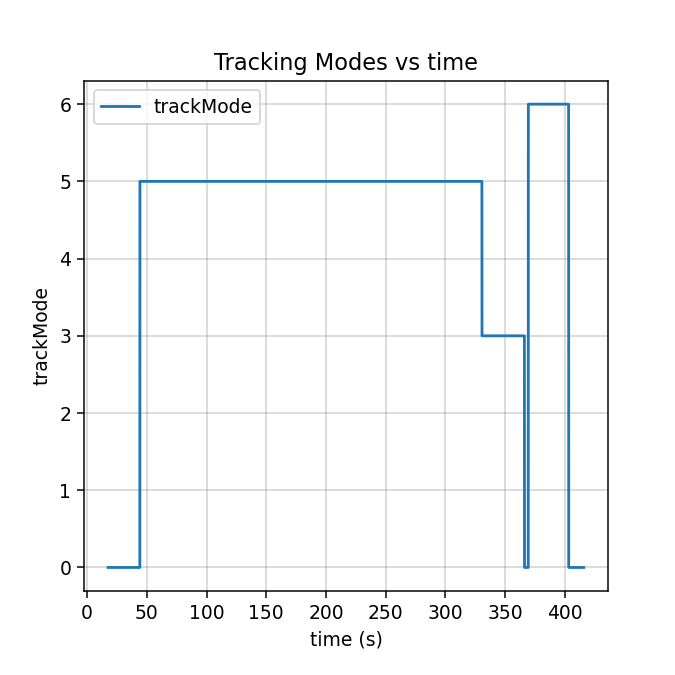

In [41]:
%matplotlib notebook
plt.figure(figsize=(5,5))
plt.plot(timestamp/1000,trackMode)
plt.ylabel('trackMode')
plt.xlabel('time (s)')
plt.title('Tracking Modes vs time')
plt.legend(['trackMode'],loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
plt.savefig("out/jpg/3d-motion-reconstruction/trackMode-time",dpi=dpiSelected)
plt.show()

In [7]:
N=len(timestamp)
tstart=timestamp.iloc[0]/1000
tend=timestamp.iloc[-1]/1000
tduration=tend-tstart
atstep=tduration/(N-1)
print("Data points: {:.0f} ".format(N))
print("Time start: {:.3f} s".format(tstart))
print("Time end: {:.3f} s".format(tend))
print("Duration: {:.3f} s".format(tduration))
print("Avg timestep: {:.3f} s".format(atstep))
print("Avg freq: {:.2f} Hz ".format(1/atstep))

Data points: 3929 
Time start: 17.677 s
Time end: 415.736 s
Duration: 398.059 s
Avg timestep: 0.101 s
Avg freq: 9.87 Hz 


In [14]:
#Choose a tracking mode
# 0 -> None, 
# 1 -> Spotlight,
# 2 -> Follow,
# 3 -> Orbit, 
# 4 -> Profile, 
# 5 -> Party,
# 6 -> Forward with person avoidance.

selectedTrackMode=3
k=selectedTrackMode

### 3D Person Detection and drone IMU odometry tracks <a class="anchor" id="3d-tracks"></a>

<IPython.core.display.Javascript object>


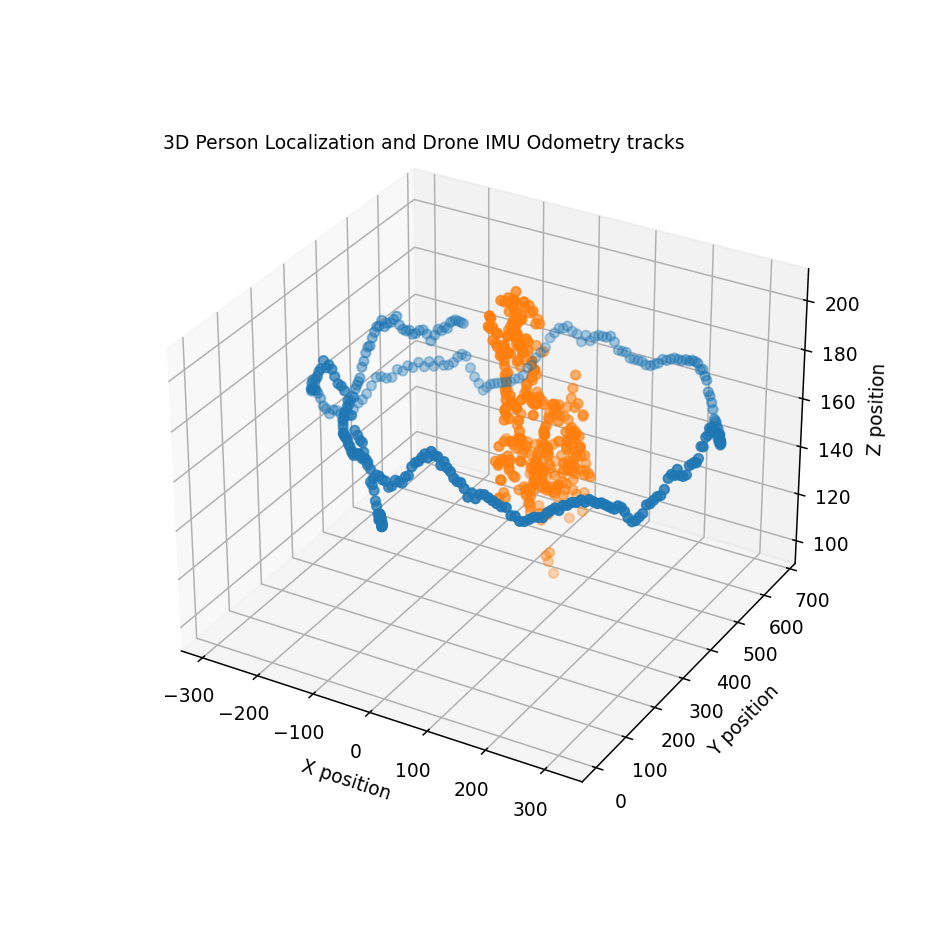

In [44]:
%matplotlib notebook
fig4 = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

#IMU odometry calculation
timeS=(timestamp[trackMode==k])/1000
vxSeq=vx[trackMode==k]
vySeq=vy[trackMode==k]
deltaTimeS=np.diff(timeS)
#drone and camera absolute position and pose
distanceXSeq=np.cumsum(10*vySeq[1:len(vySeq)]*deltaTimeS)
distanceYSeq=np.cumsum(10*vxSeq[1:len(vxSeq)]*deltaTimeS)
yawSeq=yaw[trackMode==k]
personCountSeq=(personCount[trackMode==k])
        
cameraXSeq=distanceXSeq+10*np.sin((yawSeq[1:len(yawSeq)])*np.pi/180)
cameraYSeq=distanceYSeq+10*np.cos((yawSeq[1:len(yawSeq)])*np.pi/180)
        
thetaDetf=(theta[(trackMode==k)&(personCount>0)])
yawDetf=(yaw[(trackMode==k)&(personCount>0)])
estimatedDistanceDetf=(estimatedDistance[(trackMode==k)&(personCount>0)])
        
toff=(tof[trackMode==k])
tofDetf=tof[(trackMode==k)&(personCount>0)]
yPosf=(yPos[(trackMode==k)&(personCount>0)])

xPersonRel = estimatedDistanceDetf*np.cos((90-yawDetf-thetaDetf)*np.pi/180) 
yPersonRel = estimatedDistanceDetf*np.sin((90-yawDetf-thetaDetf)*np.pi/180) 
    
xPersonAbs = distanceXSeq[personCount>0] + xPersonRel[0:-1]
yPersonAbs = distanceYSeq[personCount>0] + yPersonRel[0:-1]


zdata =tofDetf[0:len(tofDetf)]-yPosf[0:len(yPosf)]
xdata = xPersonAbs
ydata = yPersonAbs

zdrone = toff[1:len(toff)]
xdrone = distanceXSeq
ydrone = distanceYSeq
#zcamera = toff[1:len(toff)]
#xcamera = distanceXSeq+10*np.cos((yawf[1:len(yawf)])*np.pi/180) 
#ycamera = distanceYSeq+10*np.sin((yawf[1:len(yawf)])*np.pi/180) 
ax.scatter3D(xdrone, ydrone, zdrone,'ko',s=25)
ax.scatter3D(xdata, ydata, zdata,'o',s=25)

#ax.scatter3D(xcamera, ycamera, zcamera)
ax.text2D(0.05, 0.95, "3D Person Localization and Drone IMU Odometry tracks", transform=ax.transAxes)
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.savefig("out/jpg/3d-motion-reconstruction/3d-motion-reconstruction.jpg",dpi=dpiSelected)


### Animation: 3D Person Detection and drone IMU odometry tracks <a class="anchor" id="3d-animation"></a>

<IPython.core.display.Javascript object>


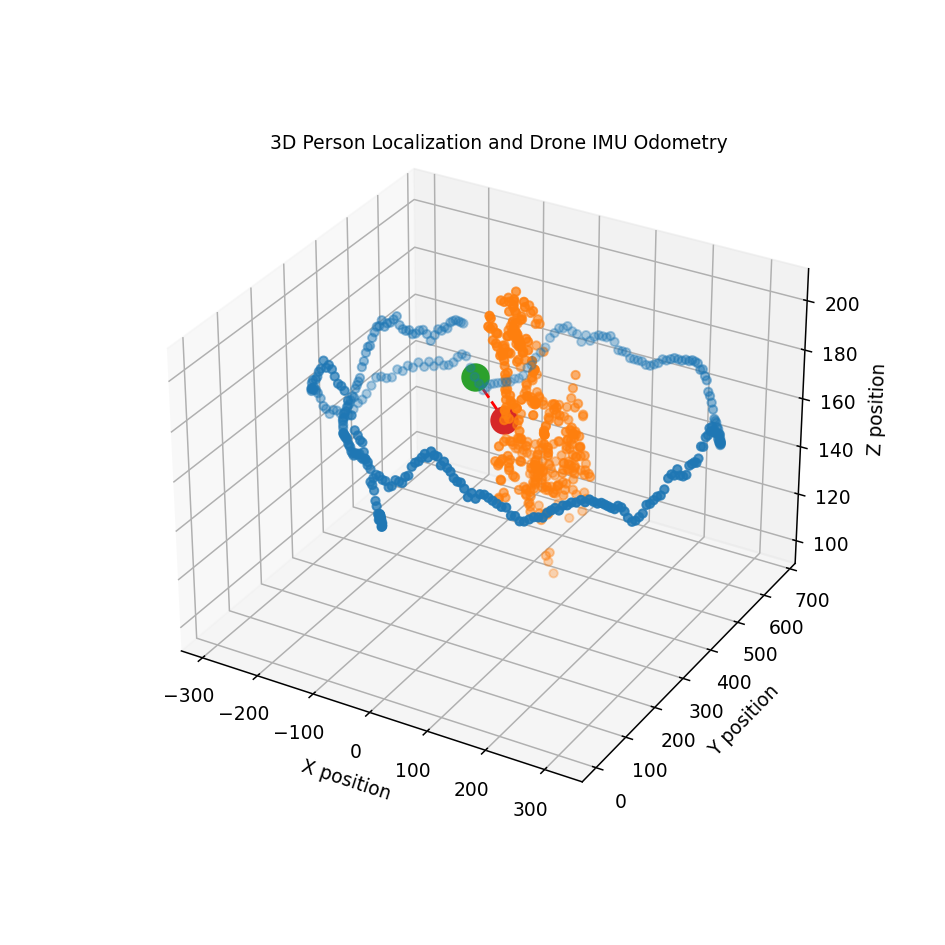

In [45]:
%matplotlib notebook
fig5 = plt.figure(figsize=(7,7))
ax = fig5.add_subplot(111,projection='3d')


ax.scatter3D(xdata, ydata, zdata,s=1)
ax.scatter3D(xdrone, ydrone, zdrone,s=1)

def draw_data3(i):       
    # Clear
    ax.cla()
    ax.scatter3D(xdrone, ydrone, zdrone,'co')
    ax.scatter3D(xdata, ydata, zdata,'go')
    
    
    ax.scatter3D(xdrone[i:i+1], ydrone[i:i+1], zdrone[i:i+1],'ko',s=200)
    id=xdrone[i:i+1].index.values.astype(int)[0]
    if(id in xdata.index.values):
        ax.scatter3D(xdata.loc[id],ydata.loc[id],zdata.loc[id],'ro',s=200)
        ax.plot([xdrone[i:i+1],xdata.loc[id]],[ydrone[i:i+1],ydata.loc[id]],[zdrone[i:i+1],zdata.loc[id]],'r--')
        
    ax.text2D(0.2, 0.95, "3D Person Localization and Drone IMU Odometry", transform=ax.transAxes)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')


anim = animation.FuncAnimation(fig5, draw_data3, interval=10, frames=len(toff)-1)   

plt.show()


### Save Animation: 3D Person Detection and drone IMU odometry tracks <a class="anchor" id="save-animation"></a>

<IPython.core.display.Javascript object>


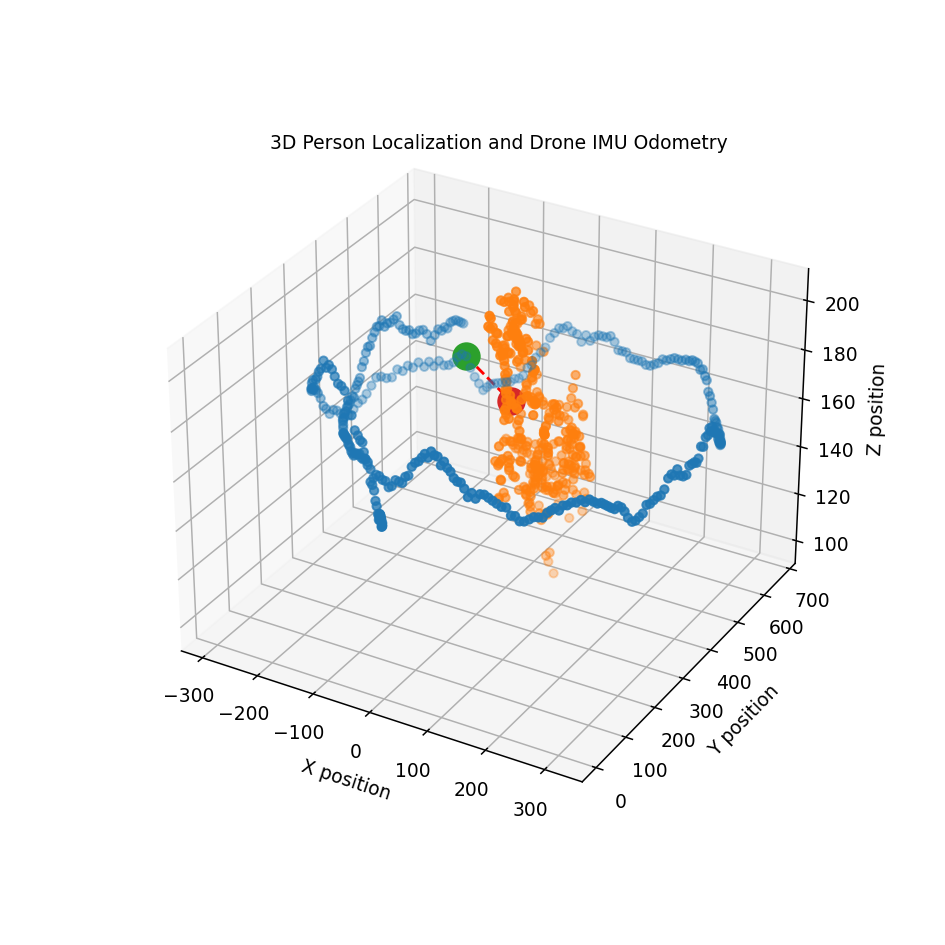

C:\WPy64-3870\python-3.8.7.amd64\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\WPy64-3870\python-3.8.7.amd64\lib\site-packages\numpy\lib\stride_tricks.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  array = np.array(array, copy=False, subok=subok)
C:\WPy64-3870\python-3.8.7.amd64\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

In [40]:
%matplotlib notebook
fig5 = plt.figure(figsize=(7,7))
ax = fig5.add_subplot(111,projection='3d')


ax.scatter3D(xdata, ydata, zdata,s=1)
ax.scatter3D(xdrone, ydrone, zdrone,s=1)

def draw_data3(i):       
    # Clear
    ax.cla()
    ax.scatter3D(xdrone, ydrone, zdrone,'co')
    ax.scatter3D(xdata, ydata, zdata,'go')
    
    
    ax.scatter3D(xdrone[i:i+1], ydrone[i:i+1], zdrone[i:i+1],'ko',s=200)
    id=xdrone[i:i+1].index.values.astype(int)[0]
    if(id in xdata.index.values):
        ax.scatter3D(xdata.loc[id],ydata.loc[id],zdata.loc[id],'ro',s=200)
        ax.plot([xdrone[i:i+1],xdata.loc[id]],[ydrone[i:i+1],ydata.loc[id]],[zdrone[i:i+1],zdata.loc[id]],'r--')
        
    ax.text2D(0.2, 0.95, "3D Person Localization and Drone IMU Odometry", transform=ax.transAxes)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')


anim = animation.FuncAnimation(fig5, draw_data3, interval=10, frames=len(toff)-1)   
f = r"out/gif/3d-motion-reconstruction/210325_3dtrackorbit.gif" 
writergif = animation.PillowWriter(fps=5) 
anim.save(f, writer=writergif,dpi=100)

plt.show()


## Telemetry Data Explanation <a class="anchor" id="data-explanation"></a>

### timestamp 
Data timestamp (milliseconds).

### trackMode
Tracking Mode coded as follows:

0 -> None, 
1 -> Spotlight,
2 -> Follow,
3 -> Orbit, 
4 -> Profile, 
5 -> Party,
6 -> Forward with person avoidance.

### telSeqId
Incremental number used to manually mark flight phases. Use Tello Vision 1D app button "Tel ID ++" to mark sequences of interest.

### personCount
Detected person count.

### personConfidence
Detection confidence for the foreground person (%).

### faceXPx, faceYPx, faceRadiusPx
Detection center and apparent face radius for the foreground person (pixels).

### angle_err
Horizontal angle error between the detected face and the center of the image (degrees)

### estimatedDistance
3D Distance between drone and the detected face (cm).

### estimatedXPos, estimatedYPos, estimatedZPos
estimatedDistance decomposed in the (X,Y,Z) drone frame reference (cm).

X is in the drone right direction, Y is in the drone down direction, Z is in the drone forward direction.

### Uyaw, Uz, Ux, Uy
Speed commands sent to the drone (approximated deg/s and cm/s)

### pitch, roll, yaw
Eulerian angles from the IMU (degrees).

### vx, vy, vz
Velocities from the IMU (decimeter/s).

X is drone initial forward direction, Y is drone initial right direction, Z is drone down direction.

### tof
Drone heigth from the Time Of Flight sensor (cm).

### batt
Drone battery level (%).

### temp
Drome temperature (°C).